源文档：[DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

环境：Win 10 + JupyterLab 3.3.2 +Conda Environment


## 1.Tensor基础使用

In [2]:
import torch as t
import numpy as np

### 1.1 快速生成Tensor

In [3]:
data = t.zeros(3,3)
data = t.ones(3,3)
data = t.rand(3,3)

#复制另一tensor的大小格式（类似于excel格式刷）
tensor = t.rand(12,34)
data = t.zeros_like(tensor)

### 1.2 查看属性

In [3]:
#查看tensor的形状
print(data.shape)
#查看tensor的类型
print(data.dtype)
#查看tensor的存储方式(cpu还是gpu)
print(data.device)

torch.Size([12, 34])
torch.float32
cpu


### 1.3 格式转换

In [4]:
#tensor转numpy.ndarray
data = t.Tensor.numpy(tensor)
type(data)



numpy.ndarray

In [5]:
#python列表转tensor
data = [1,2,3,4]
data = t.tensor(data)

#numpy.ndarray转tensor,这个最常用！！！##############
numpy = np.array([[1,  2],  [3,  4]]) 
data = t.from_numpy(numpy)
type(data)

torch.Tensor

In [6]:
#cpu存储类型转换为gpu存储类型(可用print(data.device)验证一下)
if t.cuda.is_available():
  data = data.cuda()
data.device

device(type='cuda', index=0)

### 1.4 Tensor基本操作

In [7]:
data = [[1,2,3],
        [4,5,6],
        [7,8,9]]
data1 = t.ones(3,3)
data = t.tensor(data)
data1 = t.tensor(data)

#基本运算(三种方法）
result = data+data1
result = t.add(data,data1)
data.add_(data1)

#矩阵选取(第一个位置为0)
data = t.tensor(data)
data[0,:]
#out:tensor([1, 2, 3])

C:\Users\李文彬\AppData\Local\Temp\ipykernel_74464\1390403052.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data1 = t.tensor(data)
C:\Users\李文彬\AppData\Local\Temp\ipykernel_74464\1390403052.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = t.tensor(data)


tensor([2, 4, 6])

## 2.Autograd基础使用

In [8]:
# import torch, torchvision
# model = torchvision.models.resnet18(pretrained=True)
# data = torch.rand(1, 3, 64, 64)
# labels = torch.rand(1, 1000)

**bug:模型下载失败**

因为网络问题所以运行以下代码，使用离线下载好的模型。
具体方法参考https://blog.csdn.net/haohulala/article/details/107598859

In [9]:
import torch, torchvision

model = torchvision.models.resnet18(pretrained=False)
load = torch.load("./model/resnet18-5c106cde.pth")
model.load_state_dict(load)

<All keys matched successfully>

In [10]:
#创建初始数据
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [11]:
prediction = model(data) # forward pass

这里的`prediction`是一个很大的数据，此处没有理解用意

Autograd计算每个模型的参数的梯度并将其存储在`.grad`属性中

In [12]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

加载优化器

In [13]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

进行梯度下降

In [14]:
optim.step() #gradient descent

## 3.Autograd运行原理

使用参数`requires_grad=True`来对张量a,b进行跟踪，从而了解它们的每个操作

In [15]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [16]:
a

tensor([2., 3.], requires_grad=True)

In [17]:
b

tensor([6., 4.], requires_grad=True)

In [18]:
Q = 3*a**3 - b**2
Q

tensor([-12.,  65.], grad_fn=<SubBackward0>)

假设a,b是NN的参数，Q是误差函数，在NN的训练中，我们需要计算它们的偏导

$$
Q\left( a,b \right) =3a^3-b^2
\\
Q'_a=9a
\\
Q'_b=2b
$$


当我们在Q上调用`.backward()`时，autograd会计算这些梯度并将它们存储在相应张量的`.grad`属性之中

In [19]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## 4.nn模型搭建基础使用

- Pytorch使用`torch.nn`构建神经网络

- `nn`依赖于`autograd`来定义模型

- 一个`nn.Module`主要包含了各种`layers`,输入`forward`，并返回`output`

神经网络典型的训练过程如下：

1. 定义网络，为网络设置可学习参数(或权重)

2. 迭代输入数据集，通过网络处理输入流

3. 计算损失值

4. 利用梯度下降法将梯度回馈给网络

5. 更新网络的参数(或权重)，通常使用`权重=权重-学习率*梯度`

### 1. 定义网络

我们只需要定义前向函数，然后再使用`autograd`自动去定义后向函数(计算梯度的地方)就可以了

我们可以在`forward`函数中对张量进行任意操作

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


模型的可学习参数由`net.parameters()`返回

In [21]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


### 2. 输入数据集到网络

我们在这里尝试一下随机的32*32的输入。

注意：这个网络(LeNet)的预期输入大小是`32*32`，要在MNIST数据集上使用此网络就需要把MNIST数据集中的图像大小调整为`32*32`

In [22]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0846, -0.0494,  0.1014,  0.0034,  0.0981, -0.0529, -0.1216,  0.0332,
         -0.0015, -0.0769]], grad_fn=<AddmmBackward0>)


接下来，将所有参数的梯度缓冲区和具有随机梯度的反向传播归零

In [23]:
net.zero_grad()
out.backward(torch.randn(1, 10))

在进行下一步前，我们先总结一下所学：

`torch.Tensor`：一个多维数组，支持`autograd`操作

`nn.Module`：神经网络模块，用于封装参数，支持输入输出，将参数移动到gpu的功能

`nn.Parameter`：一种张量，用以给`nn.Module`提供参数

`autograd.Function`：实现`autograd`操作的前向和后向的定义

### 3.计算损失值

定义一个损失函数，并用损失函数的值来表现输出与期望输出的偏离程度

`torch.nn`包中有很多损失函数，此处采用常用的`nn.MSELoss`，它计算输入和目标之间的均方误差

In [24]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.7181, grad_fn=<MseLossBackward0>)


如果使用它的`.grad_fn`属性来反向跟踪计算过程，你会看到如下计算图：
```
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> flatten -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss
```

In [25]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### 4.梯度下降
> 在开始梯度下降之前必须要清除现有的梯度，否则现有的梯度会影响结果输出

我们需要使用`loss.backward()`来利用损失函数进行反向传播，并看看`conv1`在`loss.backward()`之前和之后的偏差梯度。


In [26]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward：')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward：')
print(net.conv1.bias.grad)

conv1.bias.grad before backward：
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward：
tensor([ 0.0040,  0.0221, -0.0045,  0.0081, -0.0108, -0.0004])


### 5.更新网络的权重

实践中使用的最简单的更新规则是随机梯度下降 (SGD)： 

权重 = 权重 - 学习率 * 梯度

In [27]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

但是，当使用神经网络时，肯定会希望使用各种不同的更新规则，例如 SGD、Nesterov-SGD、Adam、RMSProp 等。

为此，Pytorch构建了一个包`torch.optim` 来实现所有这些方法。使用它非常简单：

In [28]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## 5.实战：训练一个分类器

通常，处理图像、文本、音频或视频数据时，就用一些python包将数据加载到 numpy 数组中，然后再把这个数组转换成一个`torch.*Tensor`。

| 数据类型 | 推荐包             |
| -------- | ------------------ |
| 图像     | **Pillow，Pillow** |
| 音频     | **scipy，librosa** |

针对图像数据，Pytorch还有一个`torchvison`的包，它自带了一些常见的数据集(ImageNet、CIFAR10、MNIST)，这样我们做训练时就直接调用加载器`torchvision.datasets`或者转换器`torchvision.datasets`而不用再去找数据下载了。

本次实验我们使用`CIFAR10`数据集构建一个简单的分类器
CIFAR-10 中的图像大小为 3x32x32，即 32x32 像素大小的 3 通道彩色图像。其中包括了‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’十种类别的图片。
![](https://pytorch.org/tutorials/_images/cifar10.png)

本次实验我们具体的步骤如下：

1. 使用`torchvision`加载和规范化`CIFAR10`训练和测试数据集

2. 定义卷积神经网络

3. 定义损失函数

4. 在训练数据上训练网络

5. 在测试数据上测试网络

### 1. 使用`torchvision`加载和规范化`CIFAR10`训练和测试数据集

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 数据集的输出是范围 [0, 1] 的 PILImage 图像。我们将它们转换为标准化范围 [-1, 1] 的张量。

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


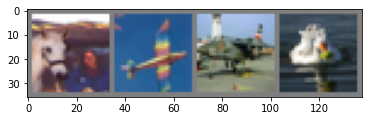

horse plane plane bird 


In [31]:
#来check一下我们下载好的数据是不是真的
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. 定义卷积神经网络

从之前的神经网络部分复制神经网络并修改它以获取 3 通道图像（而不是定义的 1 通道图像）。

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3. 定义损失函数

让我们使用具有动量的分类交叉熵作为损失函数和SGD。(SGD是什么？)

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 在训练数据上训练网络

到了事情开始变得有趣的时候了。我们只需要遍历我们的数据迭代器，并将输入提供给网络并进行优化。

In [34]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.187
[1,  4000] loss: 1.835
[1,  6000] loss: 1.661
[1,  8000] loss: 1.580
[1, 10000] loss: 1.528
[1, 12000] loss: 1.477
[2,  2000] loss: 1.405
[2,  4000] loss: 1.374
[2,  6000] loss: 1.349
[2,  8000] loss: 1.337
[2, 10000] loss: 1.301
[2, 12000] loss: 1.293
Finished Training


接下来我们将模型数据保存到`.pth`文件中，这样我们就能像前文离线下载resnet18模型那样导入我们自己建立的模型了

In [35]:
PATH = './model/cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. 在测试数据上测试网络

#### 5.1 测试集可视化

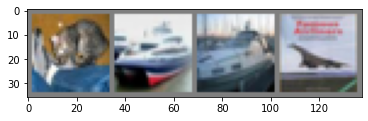

Truth:  cat   ship  ship  plane


In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

>此时我们已经在训练集上对网络进行了2次训练，此时我们需要在测试集上测试网络的学习情况

我们将通过神经网络输出的类标签与测试集中真实的类标签进行对比，声明一个数列，相同则记为1，不同则即为0，最后统计这个数列中1的占比，即为该神经网络的准确率

#### 5.2 加载模型

我们之前已经将模型保存为`cifar_net.pth`文件了，这里我们通过加载`cifar_net.pth`文件的形式来再生成一次模型（可以不这样做，此处仅作演示）

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### 5.3 抽样查看表现

现在让我们看看我们的网络认为上面的抽取的四张图像分别是什么：

输出有十列，每一列对应每一类的相似指数a(0<a<1)，相似指数越大，网络就认为这个图片更属于其对应的类别，所以，我们输出每行中拥有**最高**相似指数的标签

In [38]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
#Truth
print('    Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
#predicted
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

    Truth:  cat   ship  ship  plane
Predicted:  cat   car   plane plane


#### 5.4 查看在整个数据集上的表现

In [39]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


看起来这比随机选择一个类(10%)的效果要多了！\滑稽

#### 5.5 查看网络预测每个类别的水平

In [40]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.1 %
Accuracy for class: car   is 67.7 %
Accuracy for class: bird  is 36.2 %
Accuracy for class: cat   is 39.9 %
Accuracy for class: deer  is 51.0 %
Accuracy for class: dog   is 58.5 %
Accuracy for class: frog  is 54.7 %
Accuracy for class: horse is 53.8 %
Accuracy for class: ship  is 60.9 %
Accuracy for class: truck is 64.4 %
